# Benchmarks
### Run C++ benchmarks and store output in output.csv file for processing

In [ ]:
import pandas as pd
import subprocess
import os

def filter_lines(file_path, keywords):
    filtered_lines = []
    with open(file_path, 'r') as file:
        for line in file:
            if not any(keyword in line for keyword in keywords):
                filtered_lines.append(line)
    return filtered_lines

subprocess.run("cd cpp && make run > output.csv", shell=True)
output_filename = 'cpp/output.csv'

# clean the csv file for processing
keywords = ['Running','csv', 'build', 'make', 'Building', 'executable', 'target', 'echo']
filtered_lines = filter_lines(output_filename, keywords)
with open(output_filename, 'w') as file:
    for line in filtered_lines:
        file.write(line)

### Process C++ benchmarks output and create tables from it

In [50]:
import pandas as pd

output_filename = 'cpp/output.csv'
with open(output_filename, 'r') as file:
    lines = file.readlines()

# Split the lines based on the empty line separator
table_lines = []
current_table = []

for line in lines:
    if line.strip():
        current_table.append(line)
    elif current_table:
        table_lines.append(current_table)
        current_table = []
table_lines.append(current_table)
c_tables = []

for lines in table_lines:
    table = [line.strip().split(',') for line in lines]
    df = pd.DataFrame(table[1:], columns=table[0])
    columns_to_drop = ['bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message']
    df = df.drop(columns=columns_to_drop)
    c_tables.append(df)


### Run the following cell to display C++ tables

In [ ]:
print('C++ Benchmarks')
table_names = ["Implementation 1: build eertree and use it for a string of size n",
               "Implemenation 2: build eertree and use it for a string of size n",
               "Implemenation 1: number of rich strings of size n",
               "Implementation 2: number of rich strings of size n",
                "MSUBSTR - Palindromic refain variation" ]
for idx, df in enumerate(c_tables):
    print(f"--- C++ Benchmarks ---")
    print(table_names[idx])

    table_style = df.style.set_properties(**{'text-align': 'center'})

# Define a color function to apply to the cells
    def color_cell(value):
        if value == "s" or "bench" in value:
            return 'color: green'
        if value.isdigit():
            return 'color: yellow'
        return 'color: white'

    table_style = table_style.applymap(color_cell)
    display(table_style)
    print()

### Run Haskell benchmarks and store output in output.txt file for processing

In [13]:
output_filename = 'hs/output.txt'  

subprocess.run('cd hs && stack bench 2> output.txt', shell=True, check=True)

# Clean the ouput:
# keywords = ['FINISH','Completed', 'RUNNING...', 'Running']
keywords = ['Completed', 'Running']
filtered_lines = filter_lines(output_filename, keywords)
with open(output_filename, 'w') as file:
    for line in filtered_lines:
        file.write(line)

### Process haskell benchmarks and create tables for it

In [14]:
import pandas as pd

with open('hs/output.txt', 'r') as file:
    lines = file.readlines()

haskell_dfs = []
current_benchmark = None
current_data = []

for line in lines:
    line = line.strip()
    
    # Check if it is a new benchmark
    if 'RUNNING...' in line:
        current_benchmark = line.split(' ')[-1]
    elif 'FINISH' in line :
        df = pd.DataFrame(current_data, columns=['Metric', current_benchmark])
        haskell_dfs.append(df)
        
        current_benchmark = None
        current_data = []
    elif line:
        metric, value = line.split(" ", 1)
        metric = metric.strip()
        value = value.strip()
        
        current_data.append([metric, value])

### Run the following cell to display haskell tables

In [ ]:
# Print the created dataframes
table_names = ['List', 'Msubstr', 'Node', 'Rich', 'Simple']
for idx, df in enumerate(haskell_dfs):
    print(f"--- haskell ---")
    print(table_names[idx])

    table_style = df.style.set_properties(**{'text-align': 'center'})
    display(table_style)
    print()


### Gnerate graphs from benchmarks output:

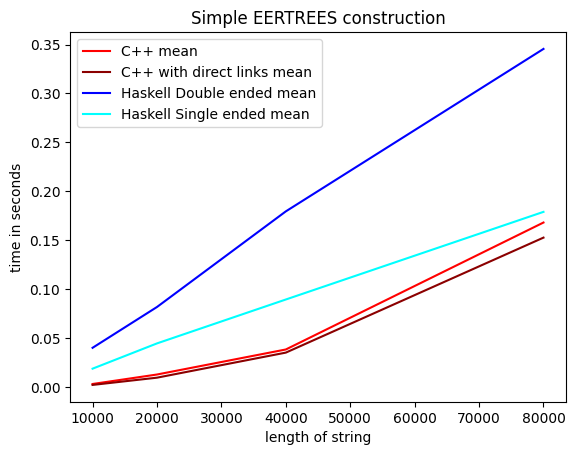

In [52]:
# Manual extraction of desired values
import matplotlib.pyplot as plt
import numpy as np
def second_conversion(str):
    if(str == "ns"):
        return 0.000000001
    if(str == "μs"):
        return 0.000001
    if(str == "ms"):
        return 0.001
    if(str == "cs"):
        return 0.01
    if(str == "s"):
        return 1.0
    print(f"UNKNOWN {str}")
    return 1.0

# create data
x = [10000, 20000, 40000, 80000]
y1, y2, y3, y4 = [], [], [], []
for index, row in c_tables[0].iterrows():
    if "mean" in row[0]:
        y1.append(float(row[2]))
for index, row in c_tables[1].iterrows():
    if "mean" in row[0]:
        y3.append(float(row[2]))
# plot lines
plt.plot(x, y1, label = "C++ mean", color='red')
plt.plot(x, y3, label = "C++ with direct links mean", color='darkred')

y5, y6 = [], []
desired = False
for index, row in haskell_dfs[4].iterrows():
    if "@26/len" in row[1]:
        desired = True
    if desired and "mean" in row[0]:
        y5.append(float(row[1].split(' ')[0]) * second_conversion(row[1].split(' ')[1]) )
    if(len(y5) == 5):
        break
for index, row in haskell_dfs[0].iterrows():
    if "@26/len" in row[1]:
        desired = True
    if desired and "mean" in row[0]:
        y6.append(float(row[1].split(' ')[0]) * second_conversion(row[1].split(' ')[1]) )
    if(len(y6) == 5):
        break
y5.pop()
y6.pop()
plt.plot(x, y5, label = "Haskell Double ended mean", color='blue')
plt.plot(x, y6, label = "Haskell Single ended mean", color='cyan')
plt.xlabel('length of string')
plt.ylabel('time in seconds')
plt.legend()
plt.title('Simple EERTREES construction')
plt.show()

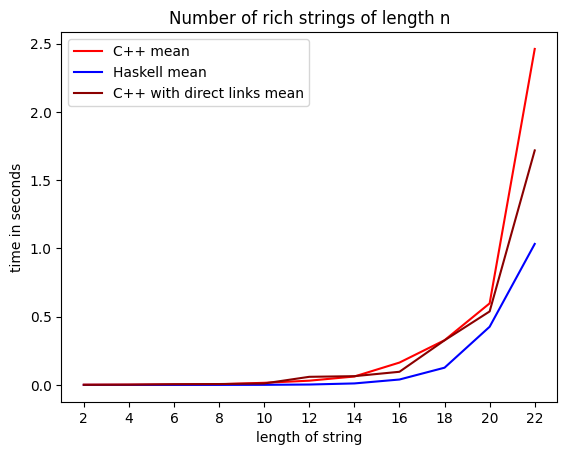

In [45]:
# Manual extraction of desired values
import matplotlib.pyplot as plt
import numpy as np
# create data
x = [2,4,6,8,10,12,14,16,18,20,22]
y1, y2 = [], []
for index, row in c_tables[2].iterrows():
    if "mean" in row[0]:
        y1.append(float(row[2]))
for index, row in c_tables[2].iterrows():
    if "median" in row[0]:
        y2.append(float(row[2]))

# plot lines
plt.xticks(x)

plt.plot(x, y1, label = "C++ mean", color='red')


y5 = []
for index, row in haskell_dfs[3].iterrows():
    if "mean" in row[0]:
        y5.append(float(row[1].split(' ')[0]) * second_conversion(row[1].split(' ')[1]) )
plt.plot(x, y5, label = "Haskell mean", color='blue')

y3 = []
for index, row in c_tables[3].iterrows():
    if "mean" in row[0]:
        y3.append(float(row[2]))

plt.plot(x, y3, label = "C++ with direct links mean", color='darkred')
plt.xlabel('length of string')
plt.ylabel('time in seconds')
plt.legend()
plt.title('Number of rich strings of length n')
plt.show()

plt.show()